# Figure 6 & 7. The overlap between splices identified by ONT sequencing, Illumina sequencing and reference annotations.

Code for making Figure 6 in the Nanopore DRS paper *Native long-read RNA sequencing of the Arabidopsis thaliana transcriptome*. For this figure we're focussing on two sets of data; first, four biological replicates of WT col-0 tissue sequenced with ONT Direct RNA Sequencing and second, six biological replicates of WT col-0 tissue sequenced with Illumina Tru-Seq poly-A+ 100bp PE sequencing.

This figure is here to illuminate the support for the uniques splices observed in the ONT DRS datasets, broken down by whether they are also detected in the Illumina data and the araport and AtRTD2 annotations.

*Note: pyupset requires a specific install of python, so make sure this notebook is running in the right conda env*

In [1]:
import re, os, sys, pysam, json, matplotlib, numpy
%matplotlib inline
import matplotlib.pyplot as plt
from snakemake.io import expand
from Bio import SeqIO
import pyupset as pyu
import pandas as pd
matplotlib.__version__

'2.0.2'

In [2]:
illumina_datasets = expand("../../datasets/Illumina_col0/STAR_alignments/TAIR10/col0/Sample_0{rep}-Col-0/Araport_col0_Sample_0{rep}-Col-0_{strand}splice_stats.json",
                           rep=[1,2,3,4,5,6], strand=["fwd","rev"])

# Datasets
import os, re
json_files = {"col0_rep1":{"jsonfile":"201901_col0_2916_splice_stats.json",
                          "path":"../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq"},
             "col0_rep2a":{"jsonfile":"201903_col0_2917_exp2_splice_stats.json",
                          "path":"../../datasets/20180405_FAH59362_WT_Col0_2917"},
             "col0_rep2b":{"jsonfile":"201901_col0_2917_splice_stats.json",
                          "path":"../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917"},
             "col0_rep3":{"jsonfile":"201901_col0_2918_splice_stats.json",
                          "path":"../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918"},
             "col0_rep4":{"jsonfile":"201901_col0_2919_splice_stats.json",
                          "path":"../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919"},
             "col0_5padapter_rep1":{"jsonfile":"201902_col0_2916_5adapter_exp2_splice_stats.json",
                                    "path":"../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916"},
             "col0_5padapter_rep2":{"jsonfile":"201902_col0_2918_5adapter_splice_stats.json",
                                    "path":"../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918"}}

minION_datasets=[]
for keystr in json_files.keys():
    fullpath = os.path.join(json_files[keystr]["path"], "splicing/TAIR10/",
                            json_files[keystr]["jsonfile"])
    minION_datasets.append(fullpath)

json_files = {"col0_rep1":{"jsonfile":"201901_col0_2916_error_corrected_splice_stats.json",
                           "path":"../../error_corrected_datasets/splicing/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq"},
             "col0_rep2a":{"jsonfile":"201903_col0_2917_exp2_error_corrected_splice_stats.json",
                           "path":"../../error_corrected_datasets/splicing/20180405_FAH59362_WT_Col0_2917"},
             "col0_rep2b":{"jsonfile":"201901_col0_2917_error_corrected_splice_stats.json",
                           "path":"../../error_corrected_datasets/splicing/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917"},
             "col0_rep3":{"jsonfile":"201901_col0_2918_error_corrected_splice_stats.json",
                          "path":"../../error_corrected_datasets/splicing/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918"},
             "col0_rep4":{"jsonfile":"201901_col0_2919_error_corrected_splice_stats.json",
                          "path":"../../error_corrected_datasets/splicing/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919"},
             "col0_5padapter_rep1":{"jsonfile":"201902_col0_2916_5adapter_exp2_error_corrected_splice_stats.json",
                                    "path":"../../error_corrected_datasets/splicing/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916"},
             "col0_5padapter_rep2":{"jsonfile":"201902_col0_2918_5adapter_error_corrected_splice_stats.json",
                                    "path":"../../error_corrected_datasets/splicing/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918"}}

ec_minION_datasets=[]
for keystr in json_files.keys():
    fullpath = os.path.join(json_files[keystr]["path"],
                            json_files[keystr]["jsonfile"])
    ec_minION_datasets.append(fullpath)

In [3]:
def getSplicingDicts(datasets):
    splicing = {"canonical":{}, "noncanonical":{}}
    ds_count={}
    for dataset in datasets:
        these_splices = json.load(open(dataset,"r"))
        ds_count[dataset] = these_splices.keys()
        print("parsing {} splices from dataset {}...".format(len(these_splices.keys()),dataset))
        for splicepos in these_splices.keys():
            if these_splices[splicepos]['is_canonical']:
                key = "canonical"
            else:
                key = "noncanonical"         
            
            thismotif = "".join(these_splices[splicepos]['sites'])
            
            try:
                splicing[key][splicepos][thismotif] += len(these_splices[splicepos]["reads"])
            except KeyError:
                if splicepos not in splicing[key].keys():
                    splicing[key][splicepos] = {thismotif:len(these_splices[splicepos]["reads"])}
                else:
                    splicing[key][splicepos][thismotif] = len(these_splices[splicepos]["reads"])
    
    print("\n{} unique canonical splices.".format(len(splicing["canonical"].keys())))
    print("{} unique non-canonical splices.\n".format(len(splicing["noncanonical"].keys())))
    return(splicing, ds_count)

In [4]:
illumina_unique_splices, illumina_ds_splicecounts = getSplicingDicts(illumina_datasets)

parsing 71742 splices from dataset ../../datasets/Illumina_col0/STAR_alignments/TAIR10/col0/Sample_01-Col-0/Araport_col0_Sample_01-Col-0_fwdsplice_stats.json...
parsing 67737 splices from dataset ../../datasets/Illumina_col0/STAR_alignments/TAIR10/col0/Sample_01-Col-0/Araport_col0_Sample_01-Col-0_revsplice_stats.json...
parsing 63818 splices from dataset ../../datasets/Illumina_col0/STAR_alignments/TAIR10/col0/Sample_02-Col-0/Araport_col0_Sample_02-Col-0_fwdsplice_stats.json...
parsing 61150 splices from dataset ../../datasets/Illumina_col0/STAR_alignments/TAIR10/col0/Sample_02-Col-0/Araport_col0_Sample_02-Col-0_revsplice_stats.json...
parsing 68946 splices from dataset ../../datasets/Illumina_col0/STAR_alignments/TAIR10/col0/Sample_03-Col-0/Araport_col0_Sample_03-Col-0_fwdsplice_stats.json...
parsing 66441 splices from dataset ../../datasets/Illumina_col0/STAR_alignments/TAIR10/col0/Sample_03-Col-0/Araport_col0_Sample_03-Col-0_revsplice_stats.json...
parsing 80594 splices from dataset

In [5]:
drs_unique_splices, drs_ds_splicecounts = getSplicingDicts(minION_datasets)

parsing 161158 splices from dataset ../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/splicing/TAIR10/201901_col0_2916_splice_stats.json...
parsing 154909 splices from dataset ../../datasets/20180405_FAH59362_WT_Col0_2917/splicing/TAIR10/201903_col0_2917_exp2_splice_stats.json...
parsing 155699 splices from dataset ../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/splicing/TAIR10/201901_col0_2917_splice_stats.json...
parsing 142014 splices from dataset ../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/splicing/TAIR10/201901_col0_2918_splice_stats.json...
parsing 141315 splices from dataset ../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/splicing/TAIR10/201901_col0_2919_splice_stats.json...
parsing 79926 splices from dataset ../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/splicing/TAIR10/201902_col0_2916_5adapter_exp2_splice_stats.json...
parsing 96570 splices from dataset ../../datasets/20180508_1

In [6]:
ec_drs_unique_splices, ec_drs_ds_splicecounts = getSplicingDicts(ec_minION_datasets)

parsing 108177 splices from dataset ../../error_corrected_datasets/splicing/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/201901_col0_2916_error_corrected_splice_stats.json...
parsing 103610 splices from dataset ../../error_corrected_datasets/splicing/20180405_FAH59362_WT_Col0_2917/201903_col0_2917_exp2_error_corrected_splice_stats.json...
parsing 104540 splices from dataset ../../error_corrected_datasets/splicing/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/201901_col0_2917_error_corrected_splice_stats.json...
parsing 100758 splices from dataset ../../error_corrected_datasets/splicing/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/201901_col0_2918_error_corrected_splice_stats.json...
parsing 99843 splices from dataset ../../error_corrected_datasets/splicing/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/201901_col0_2919_error_corrected_splice_stats.json...
parsing 65104 splices from dataset ../../error_corrected_datasets/splicing/20180411_1432_20180911_FAH84603_5

OK so I want to compare these sets of unique splices with each other and with the introns from both the araport 11 and AtRTD2 annotation. So now I need to load the annotation, parse out the introns and classify them as canonical or not...

In [7]:
# load the genome
genome = {}
for seq_record in SeqIO.parse("../../supporting_datasets/TAIR10_genome/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa", "fasta"):
    genome[seq_record.name] = seq_record

In [8]:
from parsing_routines.gff_gtf_tools import annotation
from parsing_routines.general_classes_and_functions import computeIntrons

def getAnnotationIntrons(annot, genome, chr_synonym_dic={}, parent_key="parent",
                         LOG_EVERY_N=10000):
    
    """ return a dictionary with all the introns in a given annotation """
    
    annot.clear_all()
    annot.set_feature("exons")
    exons = annot.get_selection()
    tx_exons={}
    for exon in exons:
        if type(exon.desc[parent_key]) is list:
            for parent in exon.desc[parent_key]:
                try:
                    tx_exons[parent].append(exon)
                except KeyError:
                    tx_exons[parent]=[exon]
        else:
            try:
                tx_exons[exon.desc[parent_key]].append(exon)
            except KeyError:
                tx_exons[exon.desc[parent_key]]=[exon]
    
    splice_details={}
    nlogs=1
    counter=0
    for transcript in tx_exons.keys():
        these_introns = computeIntrons(tx_exons[transcript], parent_key=parent_key, logger=None)
        for intron in these_introns:
            donor_splice_site=None
            acceptor_splice_site=None
            
            this_chrid = intron.chrid
            if intron.chrid not in genome.keys():
                if intron.chrid in chr_synonym_dic.keys() and chr_synonym_dic[intron.chrid] in genome.keys():
                    this_chrid = chr_synonym_dic[intron.chrid]
                else:
                    msg = "There is a mismatch between the annotation and " \
                          "genome chromosome IDs that is not accounted for " \
                          "in the provided chromosome synonyms list. Details: " \
                          "Annotation ID: {}, genome IDs: {}, synonyms: {} " \
                          "".format(intron.chrid, genome.keys(), chr_synonym_dic)
                    raise ValueError(msg)
            
            if intron.strand=="-":
                donor_splice_site = genome[this_chrid][intron.stop-2:intron.stop].reverse_complement()
                acceptor_splice_site = genome[this_chrid][intron.start-1:intron.start+1].reverse_complement()
            else:
                acceptor_splice_site = genome[this_chrid][intron.stop-2:intron.stop]
                donor_splice_site = genome[this_chrid][intron.start-1:intron.start+1]
            
            keystr = "{}:{}-{}".format(intron.chrid,
                                       intron.start-1,
                                       intron.stop)
            
            try:
                splice_details[keystr]["transcripts"].append(transcript)
            except:
                splice_details[keystr]={"transcripts":[transcript],
                                        "sites":(str(donor_splice_site.seq),
                                                 str(acceptor_splice_site.seq))}
                if donor_splice_site.seq!="GT" or acceptor_splice_site.seq!="AG":
                    splice_details[keystr]["is_canonical"]=False
                else:
                    splice_details[keystr]["is_canonical"]=True
        
        counter+=1
        
        if (counter % LOG_EVERY_N)==0:
            msg="processed {these} transcripts...".format(these=(nlogs*LOG_EVERY_N))
            print(msg)
            nlogs+=1
    
    return(splice_details)

In [9]:
a11_path = "../../annotations/Araport/Araport11_GFF3_genes_transposons.201606.gtf"
# load the Araport 11 annotation
a11 = annotation(a11_path, filetype="gtf", stripChr=True)
chr_synonym_dic = {"C":"Pt","M":"Mt"}
a11_introns = getAnnotationIntrons(a11, genome, chr_synonym_dic, 'transcript_id')
a11_defintrons={"canonical":{}, "noncanonical":{}}
for intron in a11_introns.keys():
    if a11_introns[intron]['is_canonical']:
        a11_defintrons["canonical"][intron]=a11_introns[intron]
    else:
        a11_defintrons["noncanonical"][intron]=a11_introns[intron]

processed 10000 transcripts...
processed 20000 transcripts...
processed 30000 transcripts...
processed 40000 transcripts...
processed 50000 transcripts...


In [10]:
# load the AtRTD2 annotation
atrtd2 = annotation("../../annotations/AtRTD/AtRTD2_19April2016.gtf", filetype="gtf", stripChr=True)
atrtd2_introns = getAnnotationIntrons(atrtd2, genome, chr_synonym_dic, "transcript_id")
atrtd2_defintrons={"canonical":{}, "noncanonical":{}}
for intron in atrtd2_introns.keys():
    if atrtd2_introns[intron]['is_canonical']:
        atrtd2_defintrons["canonical"][intron]=atrtd2_introns[intron]
    else:
        atrtd2_defintrons["noncanonical"][intron]=atrtd2_introns[intron]

processed 10000 transcripts...
processed 20000 transcripts...
processed 30000 transcripts...
processed 40000 transcripts...
processed 50000 transcripts...
processed 60000 transcripts...
processed 70000 transcripts...
processed 80000 transcripts...


# Plotting the data

OK, lets plot some of the unique splicing data, starting with how many unique splices are present in each dataset and/or annotation...

Illumina dataset unique splice counts:
	Illumina col0 01:  139479
	Illumina col0 02:  124968
	Illumina col0 03:  135387
	Illumina col0 04:  154788
	Illumina col0 05:  113502
	Illumina col0 06:  161778

ONT DRS dataset unique splice counts:
	DRS col0 01:  161158
	DRS col0 02:  202444
	DRS col0 03:  142014
	DRS col0 04:  141315

ONT DRS 5' adapter dataset unique splice counts:
	DRS col0 01 5p:   79926
	DRS col0 03 5p:   96570

Annotation unique splice counts:
	Araport 11:  135765
	AtRTD2:  151943


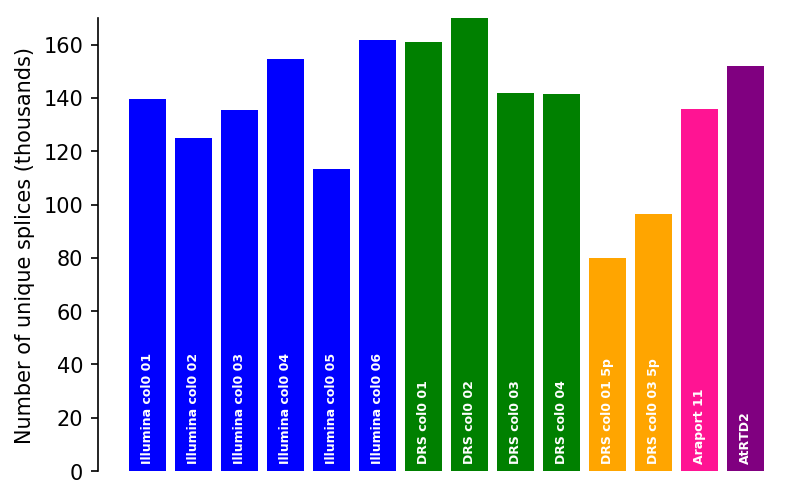

In [11]:
# plot the total splicing complement in each annotation and data file
plotnames=[]
plotvalues=[]
plotcol=[]

illdslist = sorted(list(illumina_ds_splicecounts.keys()))
illreplist = []
for ds in illdslist:
    match = re.match(".+fwd.+", ds)
    if match:
        illreplist.append((ds, re.sub("fwd","rev",ds)))

print("Illumina dataset unique splice counts:")
col="blue"
for datasetpair in illreplist:
    datasetname = "Illumina col0 {:02d}".format(int(re.match(".+Sample_0([0-9]).+",datasetpair[0]).group(1)))
    count = len(illumina_ds_splicecounts[datasetpair[0]])+len(illumina_ds_splicecounts[datasetpair[1]])
    print("\t{:>5}:{:8d}".format(datasetname,count))
    plotnames.append(datasetname)
    plotvalues.append(count)
    plotcol.append(col)

col="green"
print("\nONT DRS dataset unique splice counts:")
dsordering=['../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/splicing/TAIR10/201901_col0_2916_splice_stats.json',
('../../datasets/20180405_FAH59362_WT_Col0_2917/splicing/TAIR10/201903_col0_2917_exp2_splice_stats.json',
'../../datasets/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/splicing/TAIR10/201901_col0_2917_splice_stats.json',),
'../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/splicing/TAIR10/201901_col0_2918_splice_stats.json',
'../../datasets/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/splicing/TAIR10/201901_col0_2919_splice_stats.json']
for dataset in dsordering:
    if type(dataset) is tuple:
        datasetname = "DRS col0 {:02d}".format(int(re.match(".+col0_([0-9]+)_.+", dataset[0]).group(1))-2915)
        splicelist=[]
        for sds in dataset:
            splicelist = splicelist + list(drs_ds_splicecounts[sds])
        count = len(set(splicelist))
    else:
        datasetname = "DRS col0 {:02d}".format(int(re.match(".+col0_([0-9]+)_.+", dataset).group(1))-2915)
        count = len(drs_ds_splicecounts[dataset])
    print("\t{:>5}:{:>8d}".format(datasetname, count))
    plotnames.append(datasetname)
    plotvalues.append(count)
    plotcol.append(col)

col="orange"
print("\nONT DRS 5' adapter dataset unique splice counts:")
dsordering=['../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/splicing/TAIR10/201902_col0_2916_5adapter_exp2_splice_stats.json',
'../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/splicing/TAIR10/201902_col0_2918_5adapter_splice_stats.json'] 
for dataset in dsordering:
    datasetname = "DRS col0 {:02d} 5p".format(int(re.match(".+col0_([0-9]+)_.+", dataset).group(1))-2915)
    print("\t{:>5}:{:>8d}".format(datasetname, len(drs_ds_splicecounts[dataset])))
    plotnames.append(datasetname)
    plotvalues.append(len(drs_ds_splicecounts[dataset]))
    plotcol.append(col)

print("\nAnnotation unique splice counts:")
print("\t{:>5}:{:>8d}".format("Araport 11", len(a11_defintrons["canonical"])+len(a11_defintrons["noncanonical"])))
print("\t{:>5}:{:>8d}".format("AtRTD2", len(atrtd2_defintrons["canonical"])+len(atrtd2_defintrons["noncanonical"])))
plotnames.append("Araport 11")
plotvalues.append(len(a11_defintrons["canonical"])+len(a11_defintrons["noncanonical"]))
plotcol.append("deeppink")
                     
plotnames.append("AtRTD2")
plotvalues.append(len(atrtd2_defintrons["canonical"])+len(atrtd2_defintrons["noncanonical"]))
plotcol.append("purple")

plotvalues = numpy.array(plotvalues)/1000

fig=plt.figure(figsize=(6,4), dpi=150)
plt.bar(numpy.arange(len(plotvalues)), plotvalues, color=plotcol)
ax=plt.gca()
plt.setp(ax.get_xticklabels(), visible=False)
ax.xaxis.set_tick_params(size=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
id=0
for name in plotnames:
    plt.text(id, 3, name, color="white", rotation=90, horizontalalignment='center', verticalalignment='bottom', weight='bold', fontsize=6)
    id+=1
plt.ylabel("Number of unique splices (thousands)")
plt.ylim((0, 170))

plt.savefig("../figures/Figure_06a.png", dpi=300, transparent=True, format='png')
plt.savefig("../figures/Figure_06a.svg", format="svg")

We can make the same plot but now for the error-corrected Nanopore data...

Illumina dataset unique splice counts:
	Illumina col0 01:  139479
	Illumina col0 02:  124968
	Illumina col0 03:  135387
	Illumina col0 04:  154788
	Illumina col0 05:  113502
	Illumina col0 06:  161778

ONT DRS dataset unique splice counts:
	DRS col0 01:  108177
	DRS col0 02:  118524
	DRS col0 03:  100758
	DRS col0 04:   99843

ONT DRS 5' adapter dataset unique splice counts:
	DRS col0 01 5p:   65104
	DRS col0 03 5p:   73246

Annotation unique splice counts:
	Araport 11:  135765
	AtRTD2:  151943


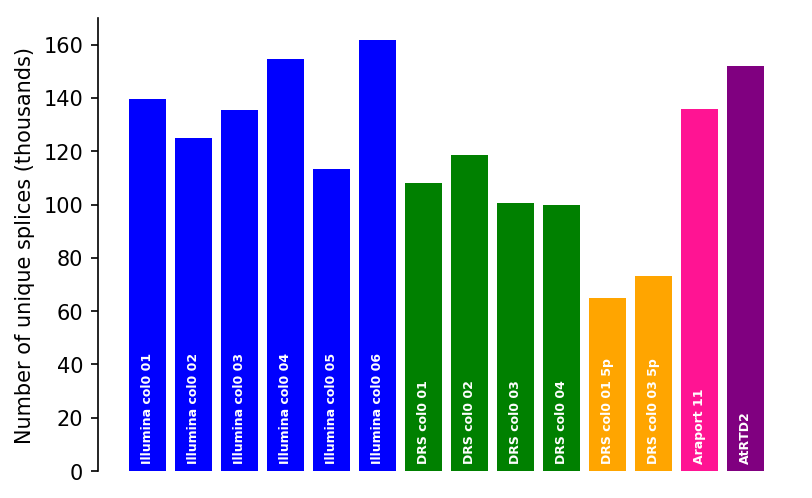

In [12]:
# plot the total splicing complement in each annotation and data file
plotnames=[]
plotvalues=[]
plotcol=[]

print("Illumina dataset unique splice counts:")
col="blue"
for datasetpair in illreplist:
    datasetname = "Illumina col0 {:02d}".format(int(re.match(".+Sample_0([0-9]).+",datasetpair[0]).group(1)))
    count = len(illumina_ds_splicecounts[datasetpair[0]])+len(illumina_ds_splicecounts[datasetpair[1]])
    print("\t{:>5}:{:8d}".format(datasetname,count))
    plotnames.append(datasetname)
    plotvalues.append(count)
    plotcol.append(col)

col="green"
print("\nONT DRS dataset unique splice counts:")
dsordering=['../../error_corrected_datasets/splicing/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/201901_col0_2916_error_corrected_splice_stats.json',
            ('../../error_corrected_datasets/splicing/20180405_FAH59362_WT_Col0_2917/201903_col0_2917_exp2_error_corrected_splice_stats.json',
            '../../error_corrected_datasets/splicing/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/201901_col0_2917_error_corrected_splice_stats.json',),
            '../../error_corrected_datasets/splicing/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/201901_col0_2918_error_corrected_splice_stats.json',
            '../../error_corrected_datasets/splicing/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/201901_col0_2919_error_corrected_splice_stats.json']
for dataset in dsordering:
    if type(dataset) is tuple:
        datasetname = "DRS col0 {:02d}".format(int(re.match(".+col0_([0-9]+)_.+", dataset[0]).group(1))-2915)
        splicelist=[]
        for sds in dataset:
            splicelist = splicelist + list(ec_drs_ds_splicecounts[sds])
        count = len(set(splicelist))
    else:
        datasetname = "DRS col0 {:02d}".format(int(re.match(".+col0_([0-9]+)_.+", dataset).group(1))-2915)
        count = len(ec_drs_ds_splicecounts[dataset])
    print("\t{:>5}:{:>8d}".format(datasetname, count))
    plotnames.append(datasetname)
    plotvalues.append(count)
    plotcol.append(col)

col="orange"
print("\nONT DRS 5' adapter dataset unique splice counts:")
dsordering=['../../error_corrected_datasets/splicing/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/201902_col0_2916_5adapter_exp2_error_corrected_splice_stats.json',
            '../../error_corrected_datasets/splicing/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/201902_col0_2918_5adapter_error_corrected_splice_stats.json']
for dataset in dsordering:
    datasetname = "DRS col0 {:02d} 5p".format(int(re.match(".+col0_([0-9]+)_.+", dataset).group(1))-2915)
    print("\t{:>5}:{:>8d}".format(datasetname, len(ec_drs_ds_splicecounts[dataset])))
    plotnames.append(datasetname)
    plotvalues.append(len(ec_drs_ds_splicecounts[dataset]))
    plotcol.append(col)

print("\nAnnotation unique splice counts:")
print("\t{:>5}:{:>8d}".format("Araport 11", len(a11_defintrons["canonical"])+len(a11_defintrons["noncanonical"])))
print("\t{:>5}:{:>8d}".format("AtRTD2", len(atrtd2_defintrons["canonical"])+len(atrtd2_defintrons["noncanonical"])))
plotnames.append("Araport 11")
plotvalues.append(len(a11_defintrons["canonical"])+len(a11_defintrons["noncanonical"]))
plotcol.append("deeppink")
                     
plotnames.append("AtRTD2")
plotvalues.append(len(atrtd2_defintrons["canonical"])+len(atrtd2_defintrons["noncanonical"]))
plotcol.append("purple")

plotvalues = numpy.array(plotvalues)/1000

fig=plt.figure(figsize=(6,4), dpi=150)
plt.bar(numpy.arange(len(plotvalues)), plotvalues, color=plotcol)
ax=plt.gca()
plt.setp(ax.get_xticklabels(), visible=False)
ax.xaxis.set_tick_params(size=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
id=0
for name in plotnames:
    plt.text(id, 3, name, color="white", rotation=90, horizontalalignment='center', verticalalignment='bottom', weight='bold', fontsize=6)
    id+=1
plt.ylabel("Number of unique splices (thousands)")
plt.ylim((0, 170))

plt.savefig("../figures/Figure_06b.png", dpi=300, transparent=True, format='png')
plt.savefig("../figures/Figure_06b.svg", format="svg")

## Set Comparisons: Canonical Splices

OK, now lets compare the sets of observed splices across the different datasets, starting with the uncorrected DRS data, then using the corrected data and finally using both alongside the illumina and annotation data. We're going to use upset plots for this.

On the four-set comparisons we're going to highlight the sets where the DRS data overlap with all the other datasets, the set where just the DRs and illumina overlap (robust new things), the sets where the DRS and the annotations overlap (things missed by illumina).

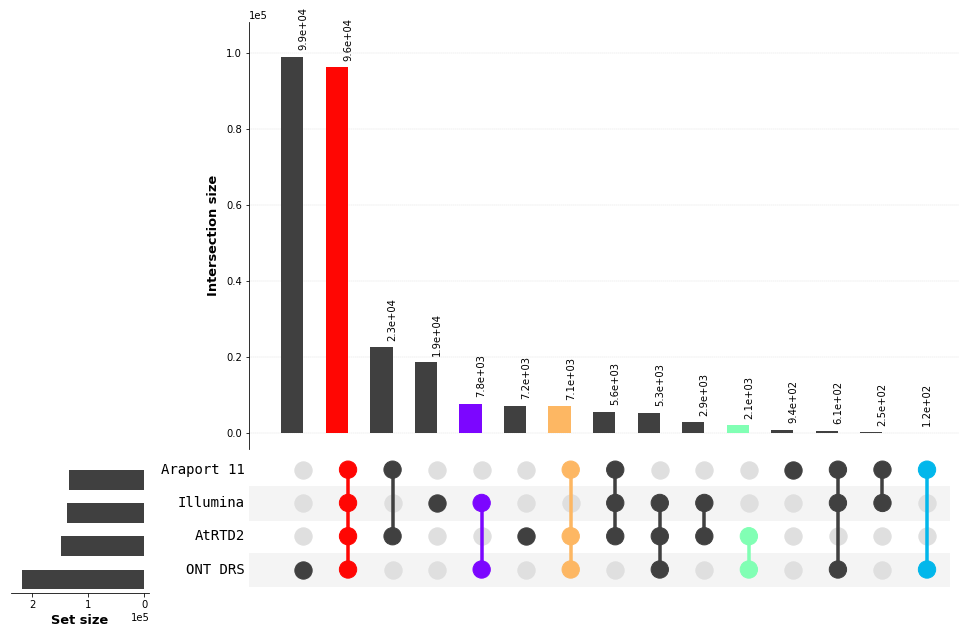

In [13]:
canonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["canonical"].keys())),
                  "ONT DRS":pd.DataFrame(list(drs_unique_splices["canonical"].keys())),
                  "Araport 11":pd.DataFrame(list(a11_defintrons["canonical"].keys())),
                  "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["canonical"].keys()))}
canonical_upset = pyu.plot(canonical_comp, sort_by='size',
                           query = [('ONT DRS', 'Illumina'),
                                    ('ONT DRS', 'Araport 11'),
                                    ('ONT DRS', 'AtRTD2'),
                                    ('ONT DRS', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'Illumina', 'Araport 11', 'AtRTD2')])

In [14]:
# great, now lets get the exact numbers for these sets...
def extractColumnData(comparison):
    
    common_columns = []
    for i, k in enumerate(comparison.keys()):
        if i == 0:
            common_columns = comparison[k].columns
        else:
            common_columns = common_columns.intersection(comparison[k].columns)
            
    x = pyu.visualisation.DataExtractor(comparison, common_columns)   
    return(x)

def getSetCounts(comparison):
    
    x = extractColumnData(comparison)
    
    i=0
    while i<len(x.ordered_dfs):
        print("{:>15}: {:>6d}".format(x.ordered_df_names[i], len(x.ordered_dfs[i])))
        i+=1
    
    keypairs={}
    for key in x.inters_df_dict.keys():
        keypairs[len(x.inters_df_dict[key])] = " + ".join(key)
    
    for keypair in sorted(list(keypairs.keys())):
        print("{:>60}: {:>6d}".format(keypairs[keypair], keypair))

getSetCounts(canonical_comp)

        ONT DRS: 218203
         AtRTD2: 149012
       Illumina: 137337
     Araport 11: 133456
                                        Araport 11 + ONT DRS:    117
                                       Illumina + Araport 11:    253
                             Illumina + ONT DRS + Araport 11:    608
                                                  Araport 11:    944
                                            AtRTD2 + ONT DRS:   2068
                                           AtRTD2 + Illumina:   2906
                                 AtRTD2 + ONT DRS + Illumina:   5346
                              AtRTD2 + Illumina + Araport 11:   5648
                               AtRTD2 + ONT DRS + Araport 11:   7121
                                                      AtRTD2:   7158
                                          Illumina + ONT DRS:   7777
                                                    Illumina:  18614
                                         AtRTD2 + Araport 11:  22580
       

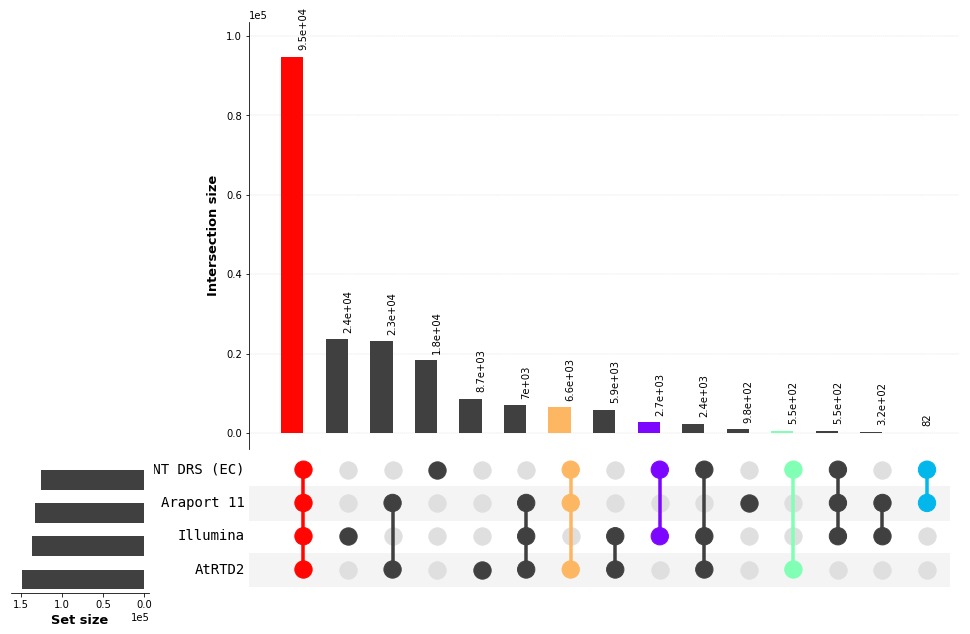

In [15]:
# now for the error corrected data
canonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["canonical"].keys())),
                  "ONT DRS (EC)":pd.DataFrame(list(ec_drs_unique_splices["canonical"].keys())),
                  "Araport 11":pd.DataFrame(list(a11_defintrons["canonical"].keys())),
                  "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["canonical"].keys()))}
canonical_upset = pyu.plot(canonical_comp, sort_by='size',
                           query = [('ONT DRS (EC)', 'Illumina'),
                                    ('ONT DRS (EC)', 'Araport 11'),
                                    ('ONT DRS (EC)', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Illumina', 'Araport 11', 'AtRTD2')])

In [16]:
getSetCounts(canonical_comp)

         AtRTD2: 149012
       Illumina: 137337
     Araport 11: 133456
   ONT DRS (EC): 125988
                                   Araport 11 + ONT DRS (EC):     82
                                       Illumina + Araport 11:    315
                        Illumina + ONT DRS (EC) + Araport 11:    546
                                       AtRTD2 + ONT DRS (EC):    553
                                                  Araport 11:    979
                            AtRTD2 + Illumina + ONT DRS (EC):   2389
                                     Illumina + ONT DRS (EC):   2711
                                           AtRTD2 + Illumina:   5863
                          AtRTD2 + ONT DRS (EC) + Araport 11:   6568
                              AtRTD2 + Illumina + Araport 11:   7010
                                                      AtRTD2:   8673
                                                ONT DRS (EC):  18316
                                         AtRTD2 + Araport 11:  23133
       

OK, now lets do the five-set comparison. Heere we are going to highlight sets where the uncorrected DRS data has support, sets where the error-corrected data has support, and sets where the uncorrected and corrected datasets agree. This is to try and visualize the glocal pattern changes caused by the error correction.

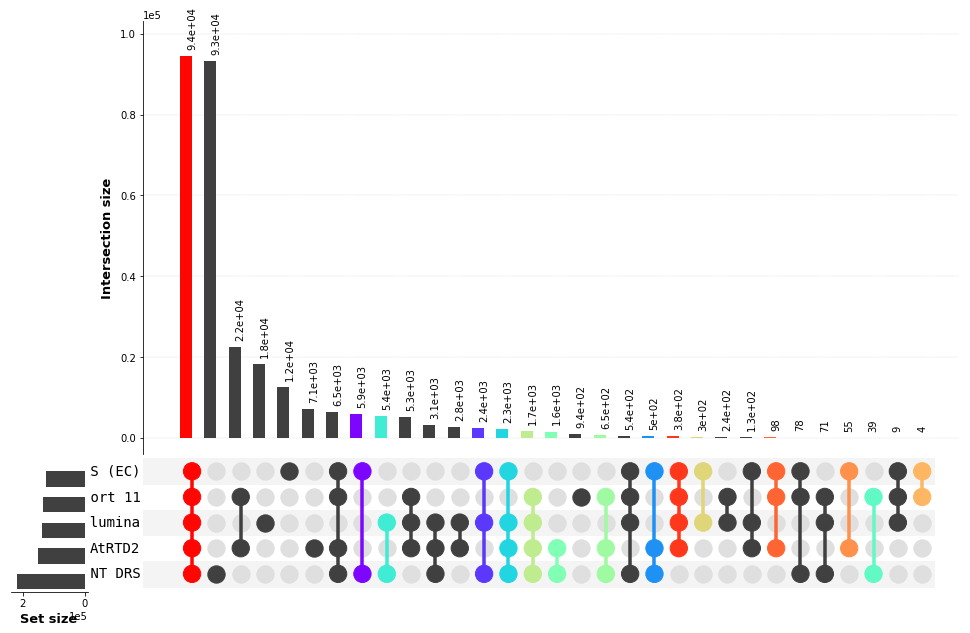

In [17]:
# now for the error corrected data
canonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["canonical"].keys())),
                  "ONT DRS":pd.DataFrame(list(drs_unique_splices["canonical"].keys())),
                  "ONT DRS (EC)":pd.DataFrame(list(ec_drs_unique_splices["canonical"].keys())),
                  "Araport 11":pd.DataFrame(list(a11_defintrons["canonical"].keys())),
                  "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["canonical"].keys()))}
canonical_upset = pyu.plot(canonical_comp, sort_by='size',
                           query = [('ONT DRS','ONT DRS (EC)'),
                                    ('ONT DRS','ONT DRS (EC)', 'Illumina'),
                                    ('ONT DRS','ONT DRS (EC)', 'Araport'),
                                    ('ONT DRS','ONT DRS (EC)', 'AtRTD2'),
                                    ('ONT DRS','ONT DRS (EC)', 'Illumina', 'Araport'),
                                    ('ONT DRS','ONT DRS (EC)', 'Illumina', 'AtRTD2'),
                                    ('ONT DRS', 'Illumina'),
                                    ('ONT DRS', 'Araport 11'),
                                    ('ONT DRS', 'AtRTD2'),
                                    ('ONT DRS', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'Illumina', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Illumina'),
                                    ('ONT DRS (EC)', 'Araport 11'),
                                    ('ONT DRS (EC)', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Illumina', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'ONT DRS (EC)', 'Illumina', 'Araport 11', 'AtRTD2')
                                   ])

plt.savefig("../figures/Figure_07a.png", dpi=300, transparent=True, format='png')
plt.savefig("../figures/Figure_07a.svg", format="svg")

In [18]:
getSetCounts(canonical_comp)

        ONT DRS: 218203
         AtRTD2: 149012
       Illumina: 137337
     Araport 11: 133456
   ONT DRS (EC): 125988
                                   Araport 11 + ONT DRS (EC):      4
                        Illumina + ONT DRS (EC) + Araport 11:      9
                                        Araport 11 + ONT DRS:     39
                                       AtRTD2 + ONT DRS (EC):     55
                             Illumina + ONT DRS + Araport 11:     71
                         Araport 11 + ONT DRS + ONT DRS (EC):     78
                          AtRTD2 + ONT DRS (EC) + Araport 11:     98
                            AtRTD2 + Illumina + ONT DRS (EC):    128
                                       Illumina + Araport 11:    244
                                     Illumina + ONT DRS (EC):    301
               AtRTD2 + Illumina + ONT DRS (EC) + Araport 11:    380
                             AtRTD2 + ONT DRS + ONT DRS (EC):    498
              Illumina + ONT DRS + ONT DRS (EC) + Ar

## Set Comparisons: non-canonical splicing

Now we're going to make the same set of comparisons for the non-canonical splicing data...

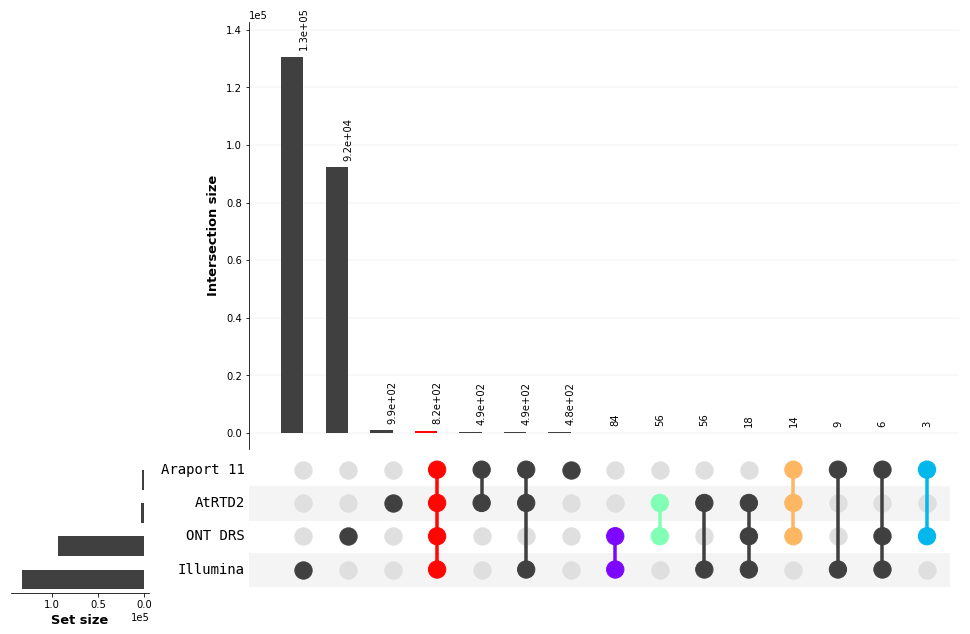

In [19]:
noncanonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["noncanonical"].keys())),
                     "ONT DRS":pd.DataFrame(list(drs_unique_splices["noncanonical"].keys())),
                     "Araport 11":pd.DataFrame(list(a11_defintrons["noncanonical"].keys())),
                     "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["noncanonical"].keys()))}
noncanonical_upset = pyu.plot(noncanonical_comp, sort_by='size',
                           query = [('ONT DRS', 'Illumina'),
                                    ('ONT DRS', 'Araport 11'),
                                    ('ONT DRS', 'AtRTD2'),
                                    ('ONT DRS', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'Illumina', 'Araport 11', 'AtRTD2')])

In [20]:
getSetCounts(noncanonical_comp)

       Illumina: 132140
        ONT DRS:  93275
         AtRTD2:   2931
     Araport 11:   2309
                                        Araport 11 + ONT DRS:      3
                             Illumina + ONT DRS + Araport 11:      6
                                       Illumina + Araport 11:      9
                               AtRTD2 + ONT DRS + Araport 11:     14
                                 Illumina + ONT DRS + AtRTD2:     18
                                            AtRTD2 + ONT DRS:     56
                                          Illumina + ONT DRS:     84
                                                  Araport 11:    477
                              Illumina + AtRTD2 + Araport 11:    487
                                         AtRTD2 + Araport 11:    494
                    Illumina + ONT DRS + AtRTD2 + Araport 11:    819
                                                      AtRTD2:    987
                                                     ONT DRS:  92275
       

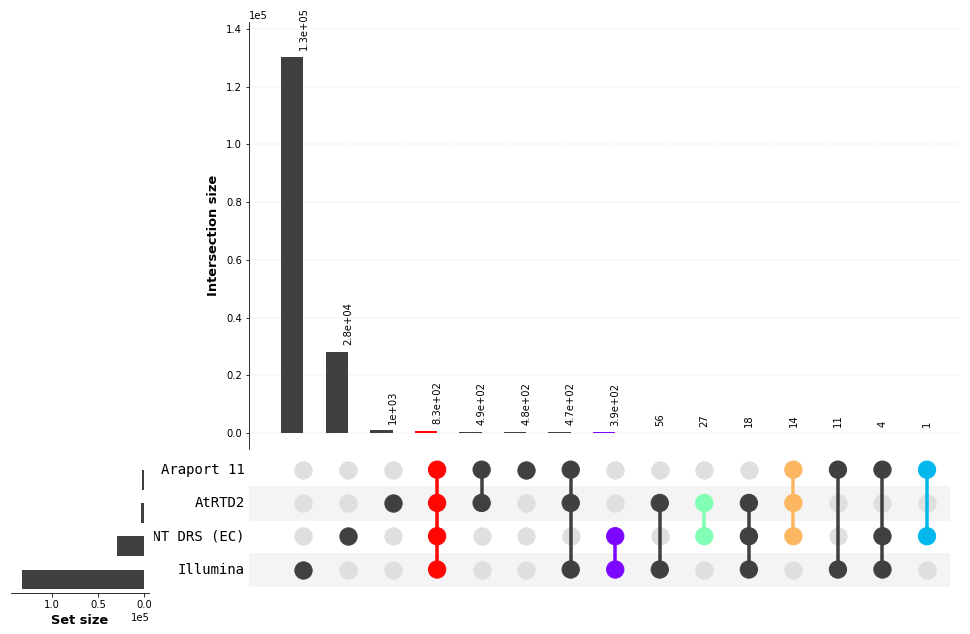

In [21]:
noncanonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["noncanonical"].keys())),
                     "ONT DRS (EC)":pd.DataFrame(list(ec_drs_unique_splices["noncanonical"].keys())),
                     "Araport 11":pd.DataFrame(list(a11_defintrons["noncanonical"].keys())),
                     "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["noncanonical"].keys()))}
noncanonical_upset = pyu.plot(noncanonical_comp, sort_by='size',
                           query = [('ONT DRS (EC)', 'Illumina'),
                                    ('ONT DRS (EC)', 'Araport 11'),
                                    ('ONT DRS (EC)', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Illumina', 'Araport 11', 'AtRTD2')])

In [22]:
getSetCounts(noncanonical_comp)

       Illumina: 132140
   ONT DRS (EC):  29498
         AtRTD2:   2931
     Araport 11:   2309
                                   Araport 11 + ONT DRS (EC):      1
                        Illumina + ONT DRS (EC) + Araport 11:      4
                                       Illumina + Araport 11:     11
                          AtRTD2 + ONT DRS (EC) + Araport 11:     14
                            Illumina + ONT DRS (EC) + AtRTD2:     18
                                       AtRTD2 + ONT DRS (EC):     27
                                           Illumina + AtRTD2:     56
                                     Illumina + ONT DRS (EC):    392
                              Illumina + AtRTD2 + Araport 11:    474
                                                  Araport 11:    479
                                         AtRTD2 + Araport 11:    494
               Illumina + Araport 11 + ONT DRS (EC) + AtRTD2:    832
                                                      AtRTD2:   1016
       

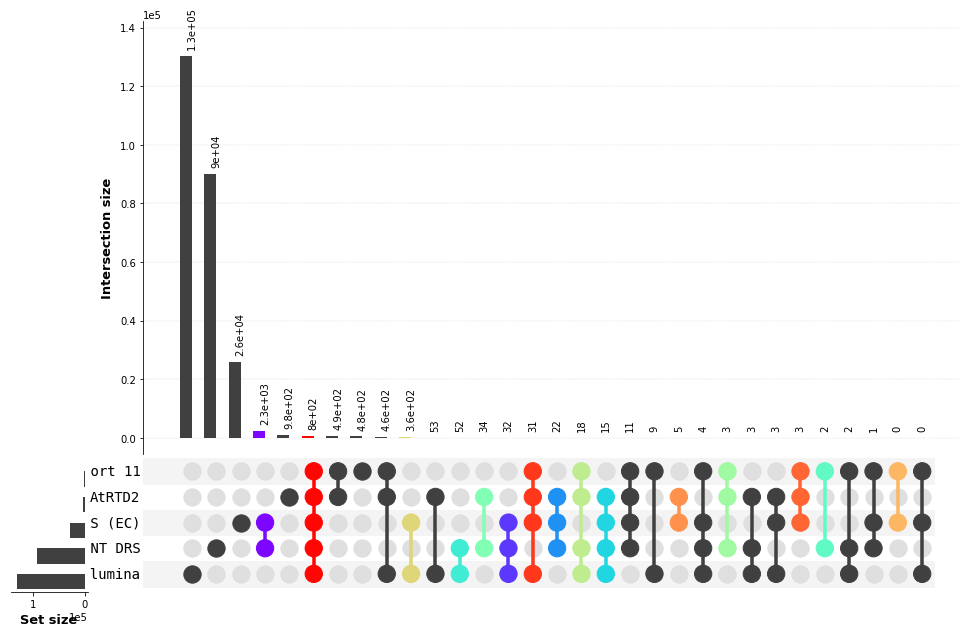

In [23]:
# now for the error corrected data
noncanonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["noncanonical"].keys())),
                  "ONT DRS":pd.DataFrame(list(drs_unique_splices["noncanonical"].keys())),
                  "ONT DRS (EC)":pd.DataFrame(list(ec_drs_unique_splices["noncanonical"].keys())),
                  "Araport 11":pd.DataFrame(list(a11_defintrons["noncanonical"].keys())),
                  "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["noncanonical"].keys()))}
noncanonical_upset = pyu.plot(noncanonical_comp, sort_by='size',
                           query = [('ONT DRS','ONT DRS (EC)'),
                                    ('ONT DRS','ONT DRS (EC)', 'Illumina'),
                                    ('ONT DRS','ONT DRS (EC)', 'Araport'),
                                    ('ONT DRS','ONT DRS (EC)', 'AtRTD2'),
                                    ('ONT DRS','ONT DRS (EC)', 'Illumina', 'Araport'),
                                    ('ONT DRS','ONT DRS (EC)', 'Illumina', 'AtRTD2'),
                                    ('ONT DRS', 'Illumina'),
                                    ('ONT DRS', 'Araport 11'),
                                    ('ONT DRS', 'AtRTD2'),
                                    ('ONT DRS', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'Illumina', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Illumina'),
                                    ('ONT DRS (EC)', 'Araport 11'),
                                    ('ONT DRS (EC)', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Illumina', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'ONT DRS (EC)', 'Illumina', 'Araport 11', 'AtRTD2')
                                   ])
plt.savefig("../figures/Figure_07b.png", dpi=300, transparent=True, format='png')
plt.savefig("../figures/Figure_07b.svg", format="svg")

In [24]:
getSetCounts(noncanonical_comp)

       Illumina: 132140
        ONT DRS:  93275
   ONT DRS (EC):  29498
         AtRTD2:   2931
     Araport 11:   2309
                        Illumina + ONT DRS (EC) + Araport 11:      0
                         Araport 11 + ONT DRS + ONT DRS (EC):      1
                             Illumina + ONT DRS + Araport 11:      2
                          AtRTD2 + ONT DRS (EC) + Araport 11:      3
              Illumina + ONT DRS + ONT DRS (EC) + Araport 11:      4
                                       AtRTD2 + ONT DRS (EC):      5
                                       Illumina + Araport 11:      9
                AtRTD2 + ONT DRS + ONT DRS (EC) + Araport 11:     11
                  Illumina + ONT DRS + ONT DRS (EC) + AtRTD2:     15
                    Illumina + ONT DRS + AtRTD2 + Araport 11:     18
                             AtRTD2 + ONT DRS + ONT DRS (EC):     22
               Illumina + Araport 11 + ONT DRS (EC) + AtRTD2:     31
                           Illumina + ONT DRS + ONT 

# Calculating some set numbers for the paper...

Lets start by calculating the number of unique splices in the ONT DRS data that are also in either annotation...

In [25]:
canonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["canonical"].keys())),
                  "ONT DRS":pd.DataFrame(list(drs_unique_splices["canonical"].keys())),
                  "Araport 11":pd.DataFrame(list(a11_defintrons["canonical"].keys())),
                  "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["canonical"].keys()))}
canonical_origdrs = extractColumnData(canonical_comp)

noncanonical_comp = {"Illumina":pd.DataFrame(list(illumina_unique_splices["noncanonical"].keys())),
                     "ONT DRS":pd.DataFrame(list(drs_unique_splices["noncanonical"].keys())),
                     "Araport 11":pd.DataFrame(list(a11_defintrons["noncanonical"].keys())),
                     "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["noncanonical"].keys()))}
noncanonical_origdrs = extractColumnData(noncanonical_comp)

def getOrigCountMatchingKey(keyName, comparisons):

    count=0
    for key in comparisons[0].inters_df_dict.keys():
        if 'ONT DRS' in key and keyName in key:
            count+=len(comparisons[0].inters_df_dict[key])
    for key in comparisons[1].inters_df_dict.keys():
        if 'ONT DRS' in key and keyName in key:
            count+=len(comparisons[1].inters_df_dict[key])

    acount = len(comparisons[0].ordered_dfs[numpy.where(comparisons[0].ordered_df_names==keyName)[0][0]])+len(comparisons[1].ordered_dfs[numpy.where(comparisons[1].ordered_df_names==keyName)[0][0]])
    print("Unique splices in ONT DRS and in {}: {} ({:.2f}%)".format(keyName, count, 100*float(count)/acount))

getOrigCountMatchingKey('Araport 11', (canonical_origdrs, noncanonical_origdrs))

Unique splices in ONT DRS and in Araport 11: 104873 (77.25%)


In [26]:
getOrigCountMatchingKey('AtRTD2', (canonical_origdrs, noncanonical_origdrs))

Unique splices in ONT DRS and in AtRTD2: 111627 (73.47%)


In [27]:
count=0
for key in canonical_origdrs.inters_df_dict.keys():
    if 'ONT DRS' in key and ('Araport 11' in key or 'AtRTD2' in key) and 'Illumina' not in key:
        count+=len(canonical_origdrs.inters_df_dict[key])
for key in noncanonical_origdrs.inters_df_dict.keys():
    if 'ONT DRS' in key and ('Araport 11' in key or 'AtRTD2' in key) and 'Illumina' not in key:
        count+=len(noncanonical_origdrs.inters_df_dict[key])

print("Unique splices in ONT DRS and either annotation, but not in Illumina: ", count)

Unique splices in ONT DRS and either annotation, but not in Illumina:  9379


In [28]:
count=0
for key in canonical_origdrs.inters_df_dict.keys():
    if 'ONT DRS' in key and 'Araport 11' in key and 'AtRTD2' not in key and 'Illumina' not in key:
        count+=len(canonical_origdrs.inters_df_dict[key])
    if 'ONT DRS' in key and 'Araport 11' not in key and 'AtRTD2' in key and 'Illumina' not in key:
        count+=len(canonical_origdrs.inters_df_dict[key])

for key in noncanonical_origdrs.inters_df_dict.keys():
    if 'ONT DRS' in key and 'Araport 11' in key and 'AtRTD2' not in key and 'Illumina' not in key:
        count+=len(noncanonical_origdrs.inters_df_dict[key])
    if 'ONT DRS' in key and 'Araport 11' not in key and 'AtRTD2' in key and 'Illumina' not in key:
        count+=len(noncanonical_origdrs.inters_df_dict[key])

print("Unique splices in ONT DRS and either annotation, but not in both and not in Illumina: ", count)

Unique splices in ONT DRS and either annotation, but not in both and not in Illumina:  2244


In [29]:
count=0
for key in canonical_origdrs.inters_df_dict.keys():
    if 'ONT DRS' in key and 'Illumina' in key and 'Araport 11' not in key and 'AtRTD2' not in key:
        count+=len(canonical_origdrs.inters_df_dict[key])
    
for key in noncanonical_origdrs.inters_df_dict.keys():
    if 'ONT DRS' in key and 'Illumina' in key and 'Araport 11' not in key and 'AtRTD2' not in key:
        count+=len(noncanonical_origdrs.inters_df_dict[key])
    
print("Unique splices in ONT DRS, not in either annotation, but also in Illumina: ", count)

Unique splices in ONT DRS, not in either annotation, but also in Illumina:  7861


In [30]:
count=0
count2=0
for key in canonical_origdrs.inters_df_dict.keys():
    if 'ONT DRS' in key:
        if len(key)==1:
            count+=len(canonical_origdrs.inters_df_dict[key])
        else:
            count2+=len(canonical_origdrs.inters_df_dict[key])
    
for key in noncanonical_origdrs.inters_df_dict.keys():
    if 'ONT DRS' in key:
        if len(key)==1:
            count+=len(noncanonical_origdrs.inters_df_dict[key])
        else:
            count2+=len(noncanonical_origdrs.inters_df_dict[key])
    
print("Unique splices in ONT DRS that are *only* in the ONT DRS data: {} ({:.2f}%)".format(count, 100*float(count)/(count2+count)))

Unique splices in ONT DRS that are *only* in the ONT DRS data: 191256 (61.40%)


In [31]:
count=0
count2=0
for key in canonical_origdrs.inters_df_dict.keys():
    if 'Illumina' in key:
        if len(key)==1:
            count+=len(canonical_origdrs.inters_df_dict[key])
        else:
            count2+=len(canonical_origdrs.inters_df_dict[key])
    
for key in noncanonical_origdrs.inters_df_dict.keys():
    if 'Illumina' in key:
        if len(key)==1:
            count+=len(noncanonical_origdrs.inters_df_dict[key])
        else:
            count2+=len(noncanonical_origdrs.inters_df_dict[key])
    
print("Unique splices in Illumina that are *only* in the Illumina data: {} ({:.2f}%)".format(count, 100*float(count)/(count2+count)))

Unique splices in Illumina that are *only* in the Illumina data: 149275 (55.39%)


# Spurious antisense

One of the most obvious features of the non-canonical upset plot is the large number of non-canonical splices found only in the strad-specific Illumina data. On the face of it this looks odd, but most of it is simple to explain. We noticed previously that the dUTP stranding protocol has a small level of error, resulting in incorrectlt stranded reads for up to ~1% of the data (see Mourao et al 2019). These reads match perfectly antisense to their original strand and includes and splicing present in the strand molecule. By definition, any of this spurious antisense signal originating from canonical splicing on the sense strand will result in a read mappign including a non-canonical splice. The contribution of this spurious antisense signal to the Illumina splices in this data is relatively easy to see by pairing up how many of the non-canonical splices and canonical splices occur at exactly the same locations.

In [32]:
inter = set(illumina_unique_splices["noncanonical"].keys()).intersection(illumina_unique_splices["canonical"].keys())
print("Candidate spurious antisense splices: {:>6d}".format(len(inter)))

Candidate spurious antisense splices: 100919


Caveats here however is that there may be a small number of RNA molecules which genuinely have a sequence which appears to originate from antisense transcription of the gene including matching the sense splicing, originating fromt he action of RNA-dependant Ribosomal Proteins acting on sense-strand RNA molecules. This contribution is expected to be small however and I think we can safely ignore it.

If we assume that the non-canonical partner in the splices that are both canonical and non-canonical are the spurious ones (due to the relative rarity of true non-canonical splicing) we can remove these from the Illumina datasets and remake the non-canonical upset plots.

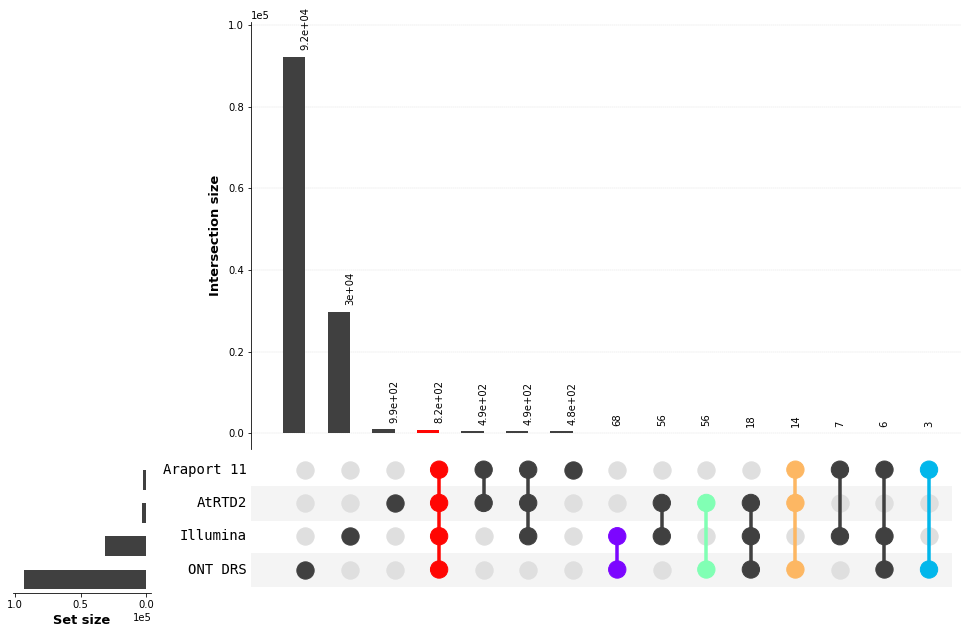

In [33]:
filtered_noncanonical=[]
for val in set(illumina_unique_splices["noncanonical"].keys()):
    if val not in inter:
        filtered_noncanonical.append(val)

noncanonical_comp = {"Illumina":pd.DataFrame(filtered_noncanonical),
                     "ONT DRS":pd.DataFrame(list(drs_unique_splices["noncanonical"].keys())),
                     "Araport 11":pd.DataFrame(list(a11_defintrons["noncanonical"].keys())),
                     "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["noncanonical"].keys()))}
noncanonical_upset = pyu.plot(noncanonical_comp, sort_by='size',
                           query = [('ONT DRS', 'Illumina'),
                                    ('ONT DRS', 'Araport 11'),
                                    ('ONT DRS', 'AtRTD2'),
                                    ('ONT DRS', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'Illumina', 'Araport 11', 'AtRTD2')])

In [34]:
getSetCounts(noncanonical_comp)

        ONT DRS:  93275
       Illumina:  31221
         AtRTD2:   2931
     Araport 11:   2309
                                        Araport 11 + ONT DRS:      3
                             Illumina + ONT DRS + Araport 11:      6
                                       Illumina + Araport 11:      7
                               AtRTD2 + ONT DRS + Araport 11:     14
                                 Illumina + ONT DRS + AtRTD2:     18
                                           Illumina + AtRTD2:     56
                                          Illumina + ONT DRS:     68
                                                  Araport 11:    479
                              Illumina + AtRTD2 + Araport 11:    487
                                         AtRTD2 + Araport 11:    494
                    Illumina + ONT DRS + AtRTD2 + Araport 11:    819
                                                      AtRTD2:    987
                                                    Illumina:  29760
       

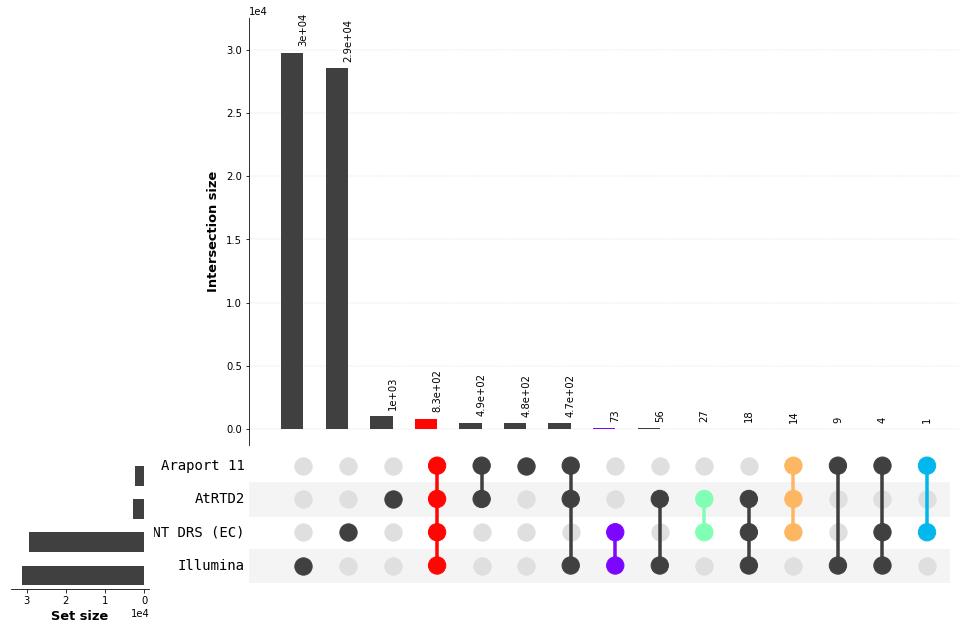

In [35]:
noncanonical_comp = {"Illumina":pd.DataFrame(filtered_noncanonical),
                     "ONT DRS (EC)":pd.DataFrame(list(ec_drs_unique_splices["noncanonical"].keys())),
                     "Araport 11":pd.DataFrame(list(a11_defintrons["noncanonical"].keys())),
                     "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["noncanonical"].keys()))}
noncanonical_upset = pyu.plot(noncanonical_comp, sort_by='size',
                           query = [('ONT DRS (EC)', 'Illumina'),
                                    ('ONT DRS (EC)', 'Araport 11'),
                                    ('ONT DRS (EC)', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Illumina', 'Araport 11', 'AtRTD2')])

In [36]:
getSetCounts(noncanonical_comp)

       Illumina:  31221
   ONT DRS (EC):  29498
         AtRTD2:   2931
     Araport 11:   2309
                                   Araport 11 + ONT DRS (EC):      1
                        Illumina + ONT DRS (EC) + Araport 11:      4
                                       Illumina + Araport 11:      9
                          AtRTD2 + ONT DRS (EC) + Araport 11:     14
                            Illumina + ONT DRS (EC) + AtRTD2:     18
                                       AtRTD2 + ONT DRS (EC):     27
                                           Illumina + AtRTD2:     56
                                     Illumina + ONT DRS (EC):     73
                              Illumina + AtRTD2 + Araport 11:    474
                                                  Araport 11:    481
                                         AtRTD2 + Araport 11:    494
               Illumina + Araport 11 + ONT DRS (EC) + AtRTD2:    832
                                                      AtRTD2:   1016
       

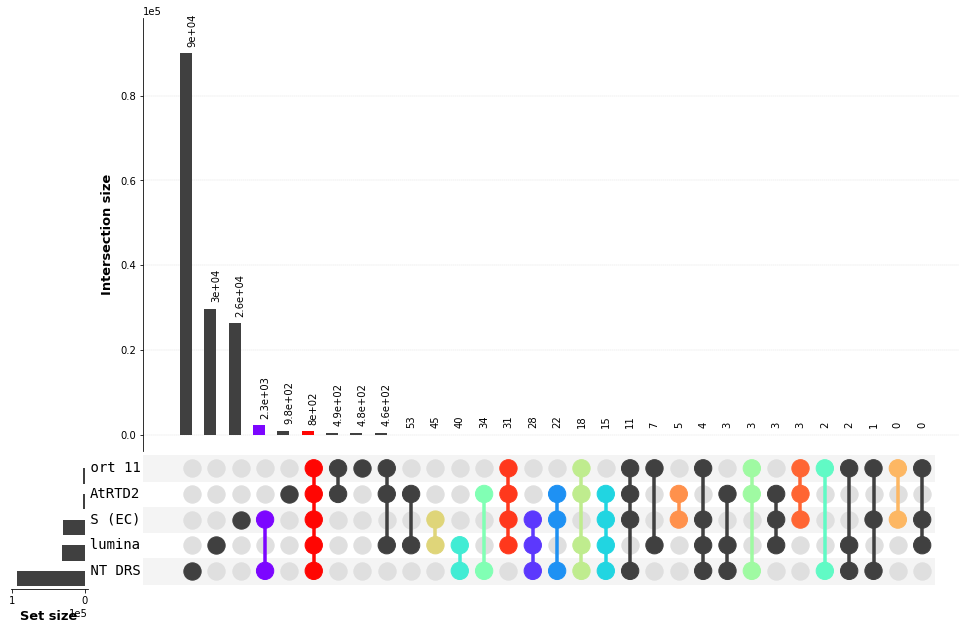

In [37]:
# now for the error corrected data
noncanonical_comp = {"Illumina":pd.DataFrame(filtered_noncanonical),
                  "ONT DRS":pd.DataFrame(list(drs_unique_splices["noncanonical"].keys())),
                  "ONT DRS (EC)":pd.DataFrame(list(ec_drs_unique_splices["noncanonical"].keys())),
                  "Araport 11":pd.DataFrame(list(a11_defintrons["noncanonical"].keys())),
                  "AtRTD2":pd.DataFrame(list(atrtd2_defintrons["noncanonical"].keys()))}
noncanonical_upset = pyu.plot(noncanonical_comp, sort_by='size',
                           query = [('ONT DRS','ONT DRS (EC)'),
                                    ('ONT DRS','ONT DRS (EC)', 'Illumina'),
                                    ('ONT DRS','ONT DRS (EC)', 'Araport'),
                                    ('ONT DRS','ONT DRS (EC)', 'AtRTD2'),
                                    ('ONT DRS','ONT DRS (EC)', 'Illumina', 'Araport'),
                                    ('ONT DRS','ONT DRS (EC)', 'Illumina', 'AtRTD2'),
                                    ('ONT DRS', 'Illumina'),
                                    ('ONT DRS', 'Araport 11'),
                                    ('ONT DRS', 'AtRTD2'),
                                    ('ONT DRS', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'Illumina', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Illumina'),
                                    ('ONT DRS (EC)', 'Araport 11'),
                                    ('ONT DRS (EC)', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS (EC)', 'Illumina', 'Araport 11', 'AtRTD2'),
                                    ('ONT DRS', 'ONT DRS (EC)', 'Illumina', 'Araport 11', 'AtRTD2')
                                   ])

In [38]:
getSetCounts(noncanonical_comp)

        ONT DRS:  93275
       Illumina:  31221
   ONT DRS (EC):  29498
         AtRTD2:   2931
     Araport 11:   2309
                        Illumina + ONT DRS (EC) + Araport 11:      0
                         Araport 11 + ONT DRS + ONT DRS (EC):      1
                             Illumina + ONT DRS + Araport 11:      2
                          AtRTD2 + ONT DRS (EC) + Araport 11:      3
              Illumina + ONT DRS + ONT DRS (EC) + Araport 11:      4
                                       AtRTD2 + ONT DRS (EC):      5
                                       Illumina + Araport 11:      7
                AtRTD2 + ONT DRS + ONT DRS (EC) + Araport 11:     11
                  Illumina + ONT DRS + ONT DRS (EC) + AtRTD2:     15
                    Illumina + ONT DRS + AtRTD2 + Araport 11:     18
                             AtRTD2 + ONT DRS + ONT DRS (EC):     22
                           Illumina + ONT DRS + ONT DRS (EC):     28
               Illumina + Araport 11 + ONT DRS (EC) 